<br>

<h1 style="text-align:center;">Image Captioning using BLIP</h1>

<br>

## Initial Setup

---

In [1]:
# Clone the BLIP repository
!git clone https://github.com/salesforce/BLIP.git
!pip install timm
!pip install fairscale
!pip install datasets

Cloning into 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 277 (delta 137), reused 136 (delta 135), pack-reused 112
Receiving objects: 100% (277/277), 7.03 MiB | 18.14 MiB/s, done.
Resolving deltas: 100% (152/152), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change the directory to BLIP
import os

os.chdir("BLIP")

In [15]:
os.mkdir("/content/drive/MyDrive/Pharaohs")
os.mkdir("/content/drive/MyDrive/Pharaohs/data")

In [16]:
!unzip /content/birme-512x512.zip -d /content/drive/MyDrive/Pharaohs/data

Archive:  /content/birme-512x512.zip
 extracting: /content/drive/MyDrive/Pharaohs/data/Design_Toscano_AI_Egyptian_Exhibit.jpg.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 065818.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 065839.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 065903.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 065932.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 065955.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 070022.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 070045.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 070124.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 070142.png  
 extracting: /content/drive/MyDrive/Pharaohs/data/Screenshot 2024-05-10 070203.png  
 extracting: /cont

In [5]:
# Import the libraries
import tqdm
from PIL import Image
import pandas as pd
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from models.blip import blip_decoder

<br>

## Generate Caption for Image Dataset

---

In [6]:
# Use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
path='/content/drive/MyDrive/Pharaohs'

In [18]:
# Rename all the images in the ./../data reporsitory
for index, filename in enumerate(os.listdir('/content/drive/MyDrive/Pharaohs/data')):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        os.rename(f'/content/drive/MyDrive/Pharaohs/data/{filename}', f'/content/drive/MyDrive/Pharaohs/data/img-({index}).png')
    else:
        continue

In [10]:
# Set the image size
image_size = 512

In [11]:
# URL BLIP model
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

# Load the model
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.97G/1.97G [00:13<00:00, 158MB/s]


reshape position embedding from 196 to 1024
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth


In [23]:
# Initialize a dataframe to store the results
results = pd.DataFrame(columns=['file_name', 'text'])

# Loop through all the images in the ./../data reporsitory
for filename in tqdm.tqdm(os.listdir('/content/drive/MyDrive/Pharaohs/data/'), ncols=120, colour="green"):

    # Check if the file is a .png file
    if filename.endswith(".png"):

        # Open the image
        img = Image.open(f'/content/drive/MyDrive/Pharaohs/data/{filename}').convert('RGB')

        # Transform the image
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
        image = transform(img).unsqueeze(0).to(device)

        # Generate the caption
        with torch.no_grad():
            #caption = model.generate(image, sample=False, num_beams=5, max_length=100, min_length=10)    # beam search
            caption = model.generate(image, sample=True, top_p=0.9, max_length=100, min_length=10)        # nucleus sampling

        # Append the results to the dataframe
        results = pd.concat([results, pd.DataFrame({'file_name': "data/"+filename, 'text': caption})], ignore_index=True)

    else:
        continue

# Save the results to a csv file
results.to_csv('/content/drive/MyDrive/Pharaohs/Pharaoh.csv', index=False)

# Display the results
results.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:19<00:00,  3.09it/s]


,file_name,text
0,data/img-(0).png,an egyptian pharaoh wearing the golden tufi ma...
1,data/img-(1).png,the egyptian queen mask with gold and jewels
2,data/img-(2).png,"the queen tuk, who has to make you cry"
3,data/img-(3).png,the egyptian god and goddess in gold
4,data/img-(4).png,an egyptian pharaoh and an image of an egyptia...


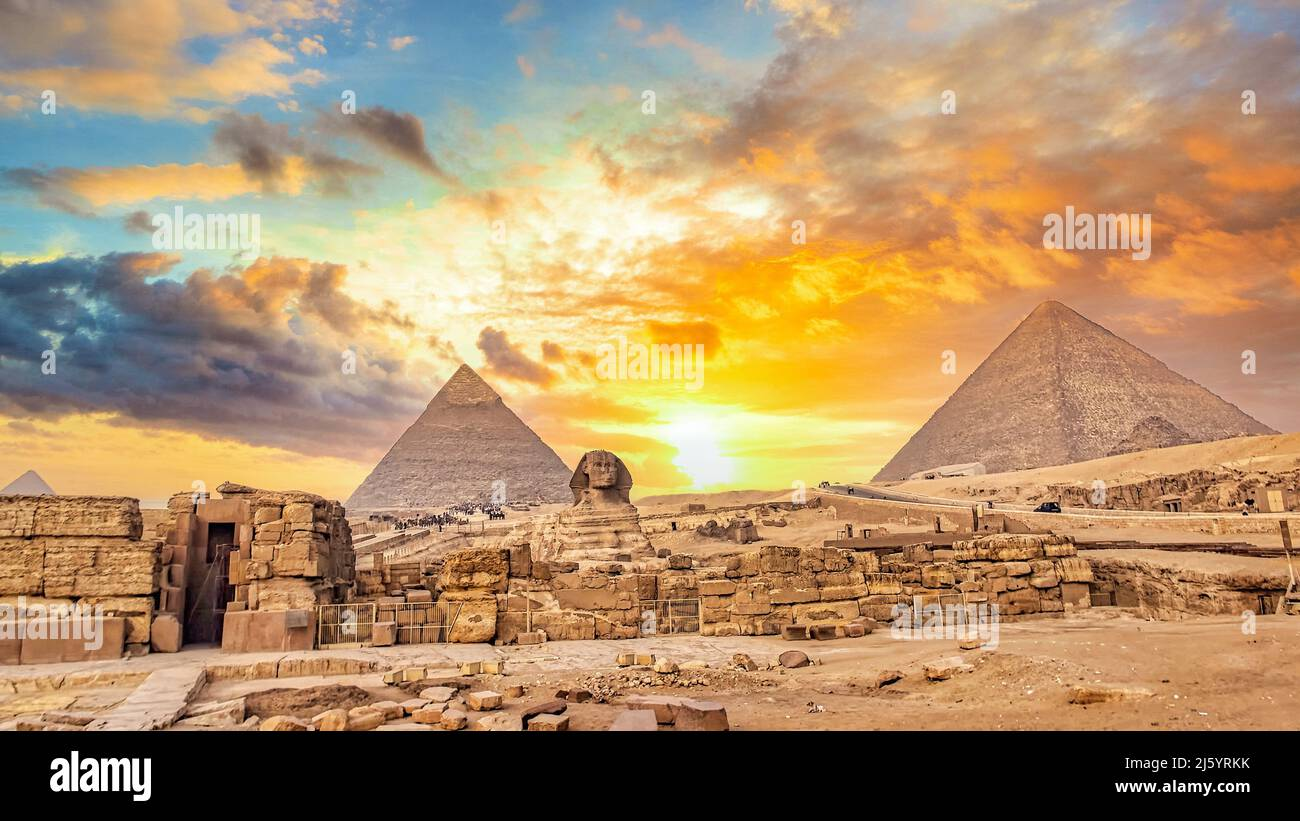

In [20]:
display(img)

In [21]:
from datasets import load_dataset

In [22]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [25]:
from huggingface_hub import HfApi

api = HfApi()

# Replace 'your-username/your-repository-name' with your actual information
# Replace '/path/to/your/local/folder' with the path to your local folder
api.upload_folder(
    folder_path='/content/drive/MyDrive/Pharaohs',
    repo_id='IMATOR/Ancient_Egyptians_model',
    repo_type='dataset'  # or 'model' or 'space' depending on your repository type
)


img-(1).png:   0%|          | 0.00/294k [00:00<?, ?B/s]

Upload 59 LFS files:   0%|          | 0/59 [00:00<?, ?it/s]

img-(11).png:   0%|          | 0.00/365k [00:00<?, ?B/s]

img-(10).png:   0%|          | 0.00/429k [00:00<?, ?B/s]

img-(12).png:   0%|          | 0.00/467k [00:00<?, ?B/s]

img-(0).png:   0%|          | 0.00/577k [00:00<?, ?B/s]

img-(13).png:   0%|          | 0.00/468k [00:00<?, ?B/s]

img-(14).png:   0%|          | 0.00/427k [00:00<?, ?B/s]

img-(15).png:   0%|          | 0.00/567k [00:00<?, ?B/s]

img-(16).png:   0%|          | 0.00/522k [00:00<?, ?B/s]

img-(17).png:   0%|          | 0.00/467k [00:00<?, ?B/s]

img-(18).png:   0%|          | 0.00/547k [00:00<?, ?B/s]

img-(19).png:   0%|          | 0.00/503k [00:00<?, ?B/s]

img-(20).png:   0%|          | 0.00/438k [00:00<?, ?B/s]

img-(2).png:   0%|          | 0.00/551k [00:00<?, ?B/s]

img-(21).png:   0%|          | 0.00/366k [00:00<?, ?B/s]

img-(22).png:   0%|          | 0.00/417k [00:00<?, ?B/s]

img-(23).png:   0%|          | 0.00/400k [00:00<?, ?B/s]

img-(24).png:   0%|          | 0.00/512k [00:00<?, ?B/s]

img-(25).png:   0%|          | 0.00/554k [00:00<?, ?B/s]

img-(26).png:   0%|          | 0.00/487k [00:00<?, ?B/s]

img-(27).png:   0%|          | 0.00/464k [00:00<?, ?B/s]

img-(28).png:   0%|          | 0.00/559k [00:00<?, ?B/s]

img-(29).png:   0%|          | 0.00/410k [00:00<?, ?B/s]

img-(3).png:   0%|          | 0.00/417k [00:00<?, ?B/s]

img-(30).png:   0%|          | 0.00/442k [00:00<?, ?B/s]

img-(32).png:   0%|          | 0.00/437k [00:00<?, ?B/s]

img-(31).png:   0%|          | 0.00/640k [00:00<?, ?B/s]

img-(33).png:   0%|          | 0.00/279k [00:00<?, ?B/s]

img-(34).png:   0%|          | 0.00/377k [00:00<?, ?B/s]

img-(35).png:   0%|          | 0.00/424k [00:00<?, ?B/s]

img-(36).png:   0%|          | 0.00/298k [00:00<?, ?B/s]

img-(37).png:   0%|          | 0.00/447k [00:00<?, ?B/s]

img-(38).png:   0%|          | 0.00/416k [00:00<?, ?B/s]

img-(39).png:   0%|          | 0.00/345k [00:00<?, ?B/s]

img-(4).png:   0%|          | 0.00/616k [00:00<?, ?B/s]

img-(40).png:   0%|          | 0.00/348k [00:00<?, ?B/s]

img-(41).png:   0%|          | 0.00/344k [00:00<?, ?B/s]

img-(42).png:   0%|          | 0.00/445k [00:00<?, ?B/s]

img-(43).png:   0%|          | 0.00/297k [00:00<?, ?B/s]

img-(44).png:   0%|          | 0.00/312k [00:00<?, ?B/s]

img-(45).png:   0%|          | 0.00/386k [00:00<?, ?B/s]

img-(46).png:   0%|          | 0.00/418k [00:00<?, ?B/s]

img-(47).png:   0%|          | 0.00/41.8k [00:00<?, ?B/s]

img-(48).png:   0%|          | 0.00/68.9k [00:00<?, ?B/s]

img-(49).png:   0%|          | 0.00/40.1k [00:00<?, ?B/s]

img-(5).png:   0%|          | 0.00/642k [00:00<?, ?B/s]

img-(50).png:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

img-(51).png:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

img-(52).png:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

img-(53).png:   0%|          | 0.00/33.2k [00:00<?, ?B/s]

img-(54).png:   0%|          | 0.00/60.9k [00:00<?, ?B/s]

img-(55).png:   0%|          | 0.00/49.1k [00:00<?, ?B/s]

img-(57).png:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

img-(56).png:   0%|          | 0.00/42.8k [00:00<?, ?B/s]

img-(58).png:   0%|          | 0.00/38.7k [00:00<?, ?B/s]

img-(6).png:   0%|          | 0.00/577k [00:00<?, ?B/s]

img-(7).png:   0%|          | 0.00/466k [00:00<?, ?B/s]

img-(8).png:   0%|          | 0.00/289k [00:00<?, ?B/s]

img-(9).png:   0%|          | 0.00/397k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/IMATOR/Ancient_Egyptians_model/commit/5d96a52f1d9727003a3831fa193d8b4b930f2ec5', commit_message='Upload folder using huggingface_hub', commit_description='', oid='5d96a52f1d9727003a3831fa193d8b4b930f2ec5', pr_url=None, pr_revision=None, pr_num=None)